## Problem Statement:


Real estate business is growing faster in many countries. Real estate
agents deal with millions of customers for buying and selling new as
well as old properties. If any customer is approaching a real estate
agent for property dealing, the first thing the agent needs to provide
the customer is property images.A good picture is worth a thousand
words’ and in fact,good pictures do help to sell a house. There can be
multiple images of properties like Bedroom,Living Room,Kitchen,
Backyard, Frontyard and Bathroom. These images for showcasing to
customers for each property with image name is easy if the properties
are in small numbers. As a business growing agent has to deal with
thousands of images to segregate and annotate. This segregation and
labeling the images for each property now becoming cumbersome
and tedious process.
Here Real Estate Image Classification mechanism comes to agents'
rescue for labeling the images.It helps agents to classify images and
labeling these images without wasting much time.

This is multiclass classification problem with six classes.

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import gc
from keras.models import Sequential,model_from_json
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten,Input,Activation,BatchNormalization,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
%load_ext tensorboard
import datetime
from tensorflow.keras.models import Model
from prettytable import PrettyTable
import prettytable
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

In [ ]:
gc.collect()

2054

##1. Exploratory Data Analysis:

Real Estate Image Classification dataset is collection of images belonging to different classes, where in each class image present in seperate folder for the specific class.

1. bedroom
2. livingroom
3. kitchen
4. bathroom
5. backyard
6. frontyard

###Preparing Image Details DataFrame: 

In [ ]:
base_path='/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/IMAGE_DATA/'
dir_lst=os.listdir(base_path)
image_path=[]
image_class=[]
image_type=[]
image_height=[]
image_width=[]
image_channel=[]
image_data=[]
for sub_dir in dir_lst:
  count=0
  image_class_dir=os.listdir(os.path.join(base_path, sub_dir))
  for file_name in tqdm(image_class_dir):   
    #count+=1
    #print(base_path+sub_dir+'/'+file_name)
    image_path.append(base_path+sub_dir+'/'+file_name)
    image_class.append(sub_dir)
    image_type.append(file_name.split('.')[1])
    tmp_data=cv2.imread(base_path+sub_dir+'/'+file_name,cv2.IMREAD_UNCHANGED)
    image_height.append(tmp_data.shape[0])
    image_width.append(tmp_data.shape[1])
    image_channel.append(tmp_data.shape[2])
    image_data.append(tmp_data)
    #if(count==5):
    #  break
data={'image_path':image_path,'image_type':image_type,'image_data':image_data,
      'image_height':image_height,'image_width':image_width,'image_channel':image_channel,
      'image_class':image_class}

image_df = pd.DataFrame(data)


100%|██████████| 884/884 [03:28<00:00,  4.24it/s]


In [ ]:
#image_df.to_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/OTHER_DATA/IMAGE_DETAILS.csv',index=False)
#image_df=pd.read_csv("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/OTHER_DATA/IMAGE_DETAILS.csv")
#image_df.to_pickle('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/image_df.pkl')
image_df=pd.read_pickle("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/image_df.pkl")
image_df.shape

(5859, 7)

Created image_df with column image_path, image_type and image_class. We need these image details for EDA as well as for further processing.

In [ ]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5859 entries, 0 to 5858
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   5859 non-null   object
 1   image_type   5859 non-null   object
 2   image_class  5859 non-null   object
dtypes: object(3)
memory usage: 137.4+ KB


####Observations:
1. Real Estate Image dataset is collection of total 5859 images, these images are belonging to differnet classes.
2. image_df having three column namely image_path, image_type and image_class,image_height,image_width,image_channel and image array data as image_data.

In [ ]:
image_df['image_class'].value_counts()

bedroom       1593
kitchen        992
frontyard      884
livingRoom     852
bathroom       793
backyard       745
Name: image_class, dtype: int64

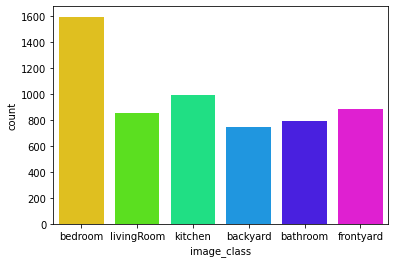

In [ ]:
# importing the required library
sns.countplot(x='image_class',data=image_df,palette='hsv')
plt.show()

####Observation: 

1. Total number of imags belong to bedroom class is 1593, this count is more    than any other class images.
2. Total number of imags belong to kitchen class is 992.
3. Total number of imags belong to frontyard class is 884.
4. Total number of imags belong to livingroom class is 852.
5. Total number of imags belong to bathroom class is 793.
6. Total number of imags belong to backyard class is 745.


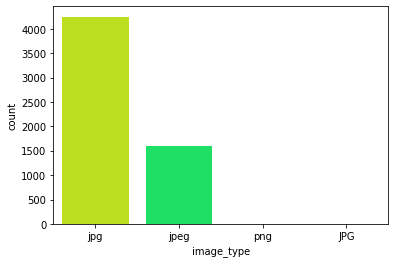

In [ ]:
# importing the required library
sns.countplot(x='image_type',data=image_df,palette='hsv')
plt.show()

####Observations:

1. More than 4000+ images having .jpj extension, these are not very good quality images.
2. Almost 1500 images having .jpeg extension, these are good quality images than images having .jpg extension.
3. There are few .png images and few images having extension of .JPG, which we need to anlyse if we should keep these images or we can remove these images from dataset.



In [ ]:
img = cv2.imread('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/IMAGE_DATA/bedroom/bedroom (992).jpg')


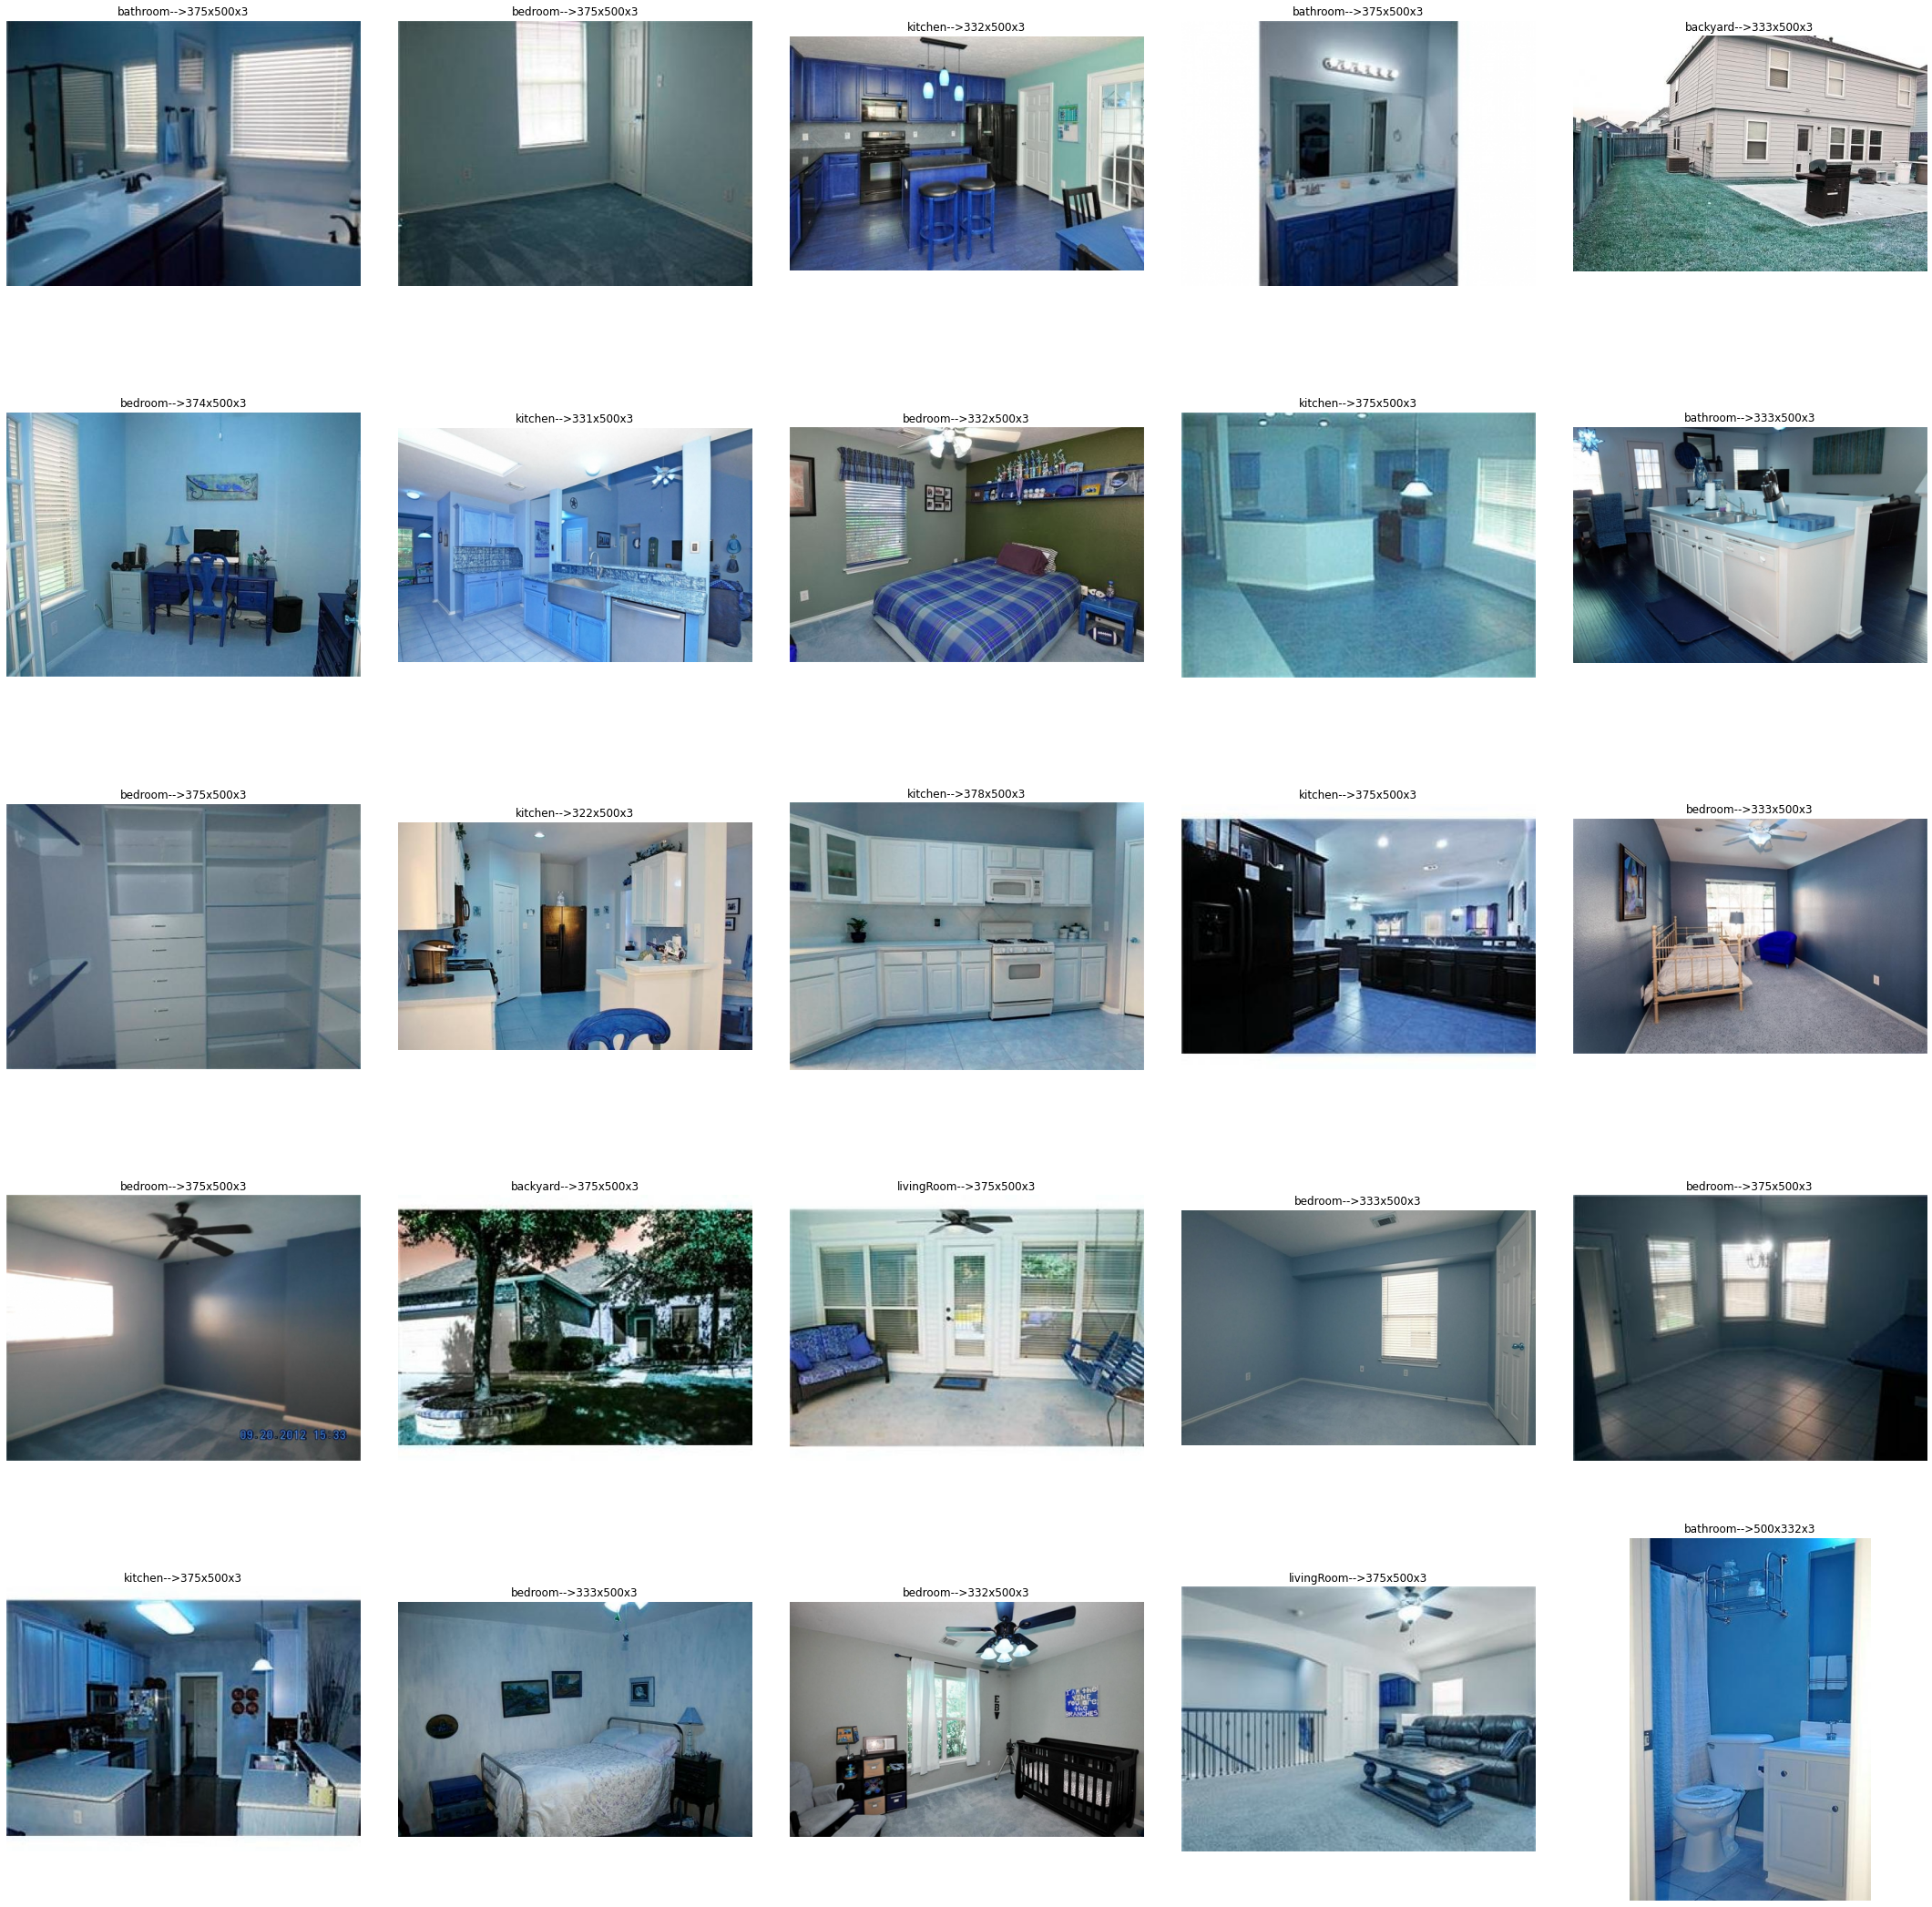

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(30,30)
fig.tight_layout()
for axes_single in axes:
  for ax in axes_single:
    print_flag=False
    idx = np.random.randint(0,5000)
    ax.imshow(image_df['image_data'][idx])
    ax.axis('off')
    ax.set_title(image_df['image_class'][idx]+'-->'+str(image_df['image_height'][idx])+'x'+str(image_df['image_width'][idx])+'x'+str(image_df['image_channel'][idx]))

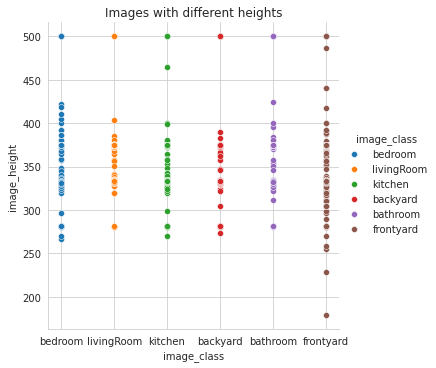

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(image_df, hue="image_class",height=5) \
   .map(sns.scatterplot, "image_class", "image_height") \
   .add_legend();
plt.title("Images with different heights")
plt.show();

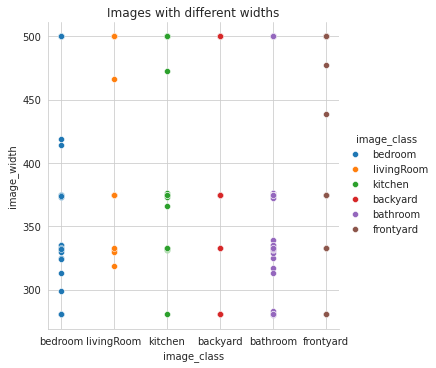

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(image_df, hue="image_class",height=5) \
   .map(sns.scatterplot, "image_class", "image_width") \
   .add_legend();
plt.title("Images with different widths")
plt.show();

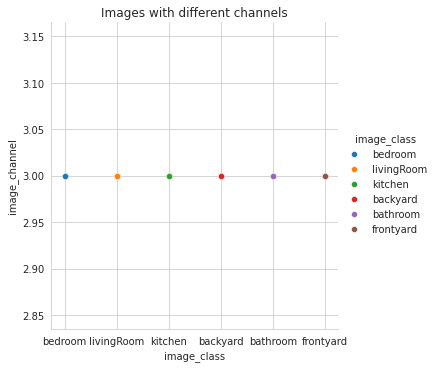

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(image_df, hue="image_class",height=5) \
   .map(sns.scatterplot, "image_class", "image_channel") \
   .add_legend();
plt.title("Images with different channels")
plt.show();

####Observations:

1. From the above grid of image we can see that not all images are of same size and also not all images of good quality.

2. We have also notice, these images width and height vary between 200-500 repectively.

3. We may need to consider making the images of same size for further processing.

4. All the images having only 3 channels.

###Image Preprocessing

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(image_df, image_df['image_class'], test_size=0.3, random_state=42)

In [ ]:
#X_train.to_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/OTHER_DATA/X_train.csv',index=False)
#X_test.to_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/OTHER_DATA/X_test.csv',index=False)
X_train=pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/OTHER_DATA/X_train.csv')
X_test=pd.read_csv('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/OTHER_DATA/X_test.csv')

In [ ]:
base_train_images_path='/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/IMAGE_LATEST_DATA/TRAIN_IMAGES/'
base_test_images_path='/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/IMAGE_LATEST_DATA/TEST_IMAGES/'

In [ ]:
for subfolder_name in list(np.unique(image_df['image_class'])):
    os.makedirs(os.path.join(base_train_images_path, subfolder_name))
    os.makedirs(os.path.join(base_test_images_path, subfolder_name))

In [ ]:
#https://thispointer.com/python-how-to-copy-files-from-one-location-to-another-using-shutil-copy/
import shutil
from tqdm import tqdm
for idx in tqdm(X_train.index):
  path=X_train["image_path"][idx]
  sub_dir=X_train['image_class'][idx]
  shutil.copy(path ,base_train_images_path+sub_dir+'/'+ os.path.basename(path))

100%|██████████| 4101/4101 [39:48<00:00,  1.72it/s]


In [ ]:
for idx in tqdm(X_test.index):
  path=X_test["image_path"][idx]
  sub_dir=X_test['image_class'][idx]
  shutil.copy(path ,base_test_images_path+sub_dir+'/'+ os.path.basename(path))

100%|██████████| 1758/1758 [17:06<00:00,  1.71it/s]


###Call Back Functions:

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 10, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_accuracy", patience = 10)

def decay_fn(epoch, lr):
    if epoch <= 10:
        return 0.001
    elif epoch > 10 and epoch <=15 :
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)


###Image Data Generator :

In [ ]:
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

ImageGenerator_train = ImageFlow.flow_from_directory(base_train_images_path,target_size=(224,224),seed=10,batch_size=32)

ImageGenerator_validation = ImageFlow.flow_from_directory(base_test_images_path,target_size=(224,224),seed=10,batch_size=32)

Found 4101 images belonging to 6 classes.
Found 1758 images belonging to 6 classes.


In [ ]:
STEP_SIZE_TRAIN=ImageGenerator_train.n//ImageGenerator_train.batch_size
STEP_SIZE_VALID=ImageGenerator_validation.n//ImageGenerator_validation.batch_size

print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)


128 54


In [ ]:
ImageGenerator_train.class_indices

{'backyard': 0,
 'bathroom': 1,
 'bedroom': 2,
 'frontyard': 3,
 'kitchen': 4,
 'livingRoom': 5}

In [ ]:
def predict_class(class_index):
  if(class_index==0):
    return 'backyard'
  elif(class_index==1):
    return 'bathroom'
  elif(class_index==2):
    return 'bedroom'
  elif(class_index==3):
    return 'frontyard'
  elif(class_index==4):
    return 'kitchen'
  else:
     return 'livingRoom'

In [ ]:
def predict_print_confusion_matrix(model_param): 
    test_pred=[]
    for row in X_test["image_data"]:
        test_pred.append(predict_class(np.argmax(model_param.predict(row))))

    cnf_mtr=confusion_matrix(X_test["image_class"],test_pred)
    labels =    ['backyard','bathroom','bedroom','frontyard','kitchen','livingRoom']
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(cnf_mtr, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

 

In [ ]:
def predict_print_model_accuracy(model_param): 
    test_pred=[]
    for row in X_test["image_data"]:
        test_pred.append(predict_class(np.argmax(model_param.predict(row))))
    
    print("Accuracy: ",accuracy_score(X_test["image_class"], test_pred))

###Simple Sequential Model:

In [ ]:
#Tensorboard

log_dir="/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/"+"sequential_model"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(1,1)))
#Batch Norm
model.add(BatchNormalization()) 

# flatten output of conv
model.add(Flatten())
# hidden layer

#Dropout
model.add(Dropout(.2))

model.add(Dense(50))
model.add(Activation('relu'))
# output layer
model.add(Dense(6))
model.add(Activation('softmax'))
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 25)      700       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 25)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 222, 222, 25)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 25)      100       
_________________________________________________________________
flatten (Flatten)            (None, 1232100)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1232100)           0         
_________________________________________________________________
dense (Dense)                (None, 50)                6

In [ ]:
model.fit(ImageGenerator_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=ImageGenerator_validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=[tensorboard_callback,reduce_lr,early_stop,lr_scheduler])

#model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Base_Model.h5")

Epoch 1/20
128/128 [==============================] - 426s 3s/step - loss: 30.9014 - accuracy: 0.2812 - val_loss: 2.6382 - val_accuracy: 0.2951
Epoch 2/20
128/128 [==============================] - 389s 3s/step - loss: 1.9458 - accuracy: 0.2883 - val_loss: 1.8539 - val_accuracy: 0.3021
Epoch 3/20
128/128 [==============================] - 445s 3s/step - loss: 1.7633 - accuracy: 0.2883 - val_loss: 1.7775 - val_accuracy: 0.3235
Epoch 4/20
128/128 [==============================] - 429s 3s/step - loss: 1.7328 - accuracy: 0.3131 - val_loss: 1.7886 - val_accuracy: 0.3356
Epoch 5/20
128/128 [==============================] - 428s 3s/step - loss: 1.7005 - accuracy: 0.3288 - val_loss: 1.7270 - val_accuracy: 0.3495
Epoch 6/20
128/128 [==============================] - 438s 3s/step - loss: 1.8626 - accuracy: 0.3384 - val_loss: 1.8613 - val_accuracy: 0.3420
Epoch 7/20
128/128 [==============================] - 401s 3s/step - loss: 1.6698 - accuracy: 0.3318 - val_loss: 1.6962 - val_accuracy: 0.398

In [ ]:
np.max(model.history.history['val_accuracy'])*100

40.27777910232544

In [ ]:
  X_test_image_data=[]
  for idx in X_test.index:
    #print(idx)
    img = cv2.imread(X_test['image_path'][idx])
    img_orginal = cv2.resize(img,(224,224),cv2.IMREAD_UNCHANGED)
    img = np.reshape(img_orginal,[1,224,224,3])
    X_test_image_data.append(img)
    #class_prob = loaded_model.predict(img)

In [ ]:
X_test['image_data']=X_test_image_data

In [ ]:
#X_test.to_pickle('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/X_test_image_input_data.pkl')
X_test=pd.read_pickle('/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/X_test_image_input_data.pkl')
X_test["image_data"][0].shape

(1, 224, 224, 3)

In [ ]:
X_test

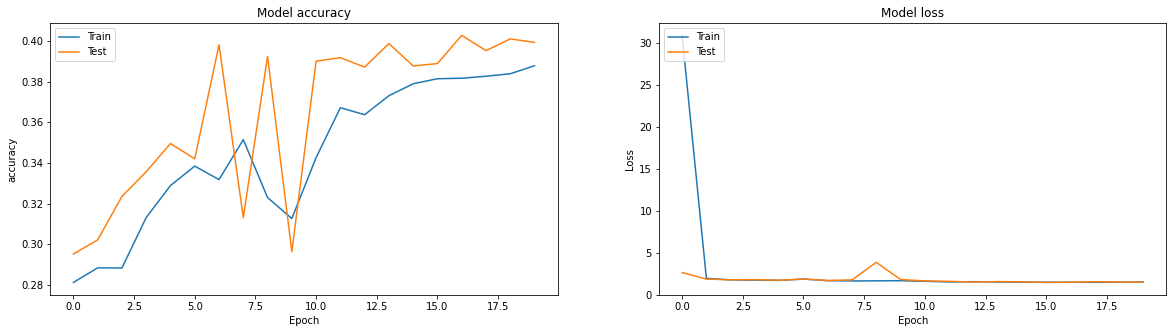

In [ ]:

# Plot training & test accuracy values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & tets loss values
plt.subplot(122)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/sequential_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Save the trained weights in to .h5 format
model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/sequential_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/sequential_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/sequential_model.h5")
print("Loaded model from disk")

Loaded model from disk


-------------------------------------------------- Confusion matrix --------------------------------------------------


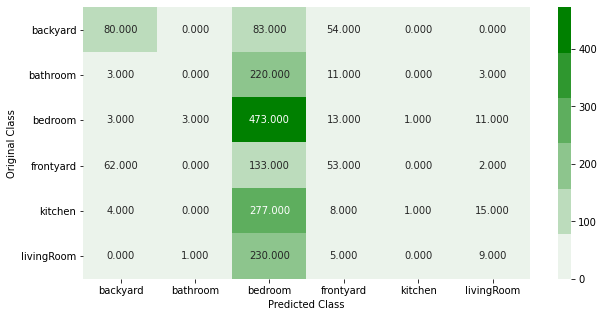

In [ ]:
predict_print_confusion_matrix(loaded_model)

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(30,30)
fig.tight_layout()
for axes_single in axes:
  for ax in axes_single:
    idx = np.random.choice(X_test.index)
    ax.axis('off')
    img = cv2.imread(X_test['image_path'][idx])
    img_orginal = cv2.resize(img,(224,224),cv2.IMREAD_UNCHANGED)
    ax.imshow(img_orginal)
    img = np.reshape(img_orginal,[1,224,224,3])
    class_prob = loaded_model.predict(img)
    ax.set_title('Actual: '+X_test['image_class'][idx]+'--> Prediction: '+predict_class(np.argmax(class_prob)))

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/AlexNet20210914-075110

#Transfer Learning:

###VGG16:

In [ ]:
VGG16_base_model=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    #pooling=None,
    #classes=None,
    #classifier_activation=None,
)
#base_model.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
VGG16_base_model.trainable = False
#Input layer
input_layer1 = Input(shape=(224,224,3),name='Input_Layer1')

#Base Model layer
input_layer2 = VGG16_base_model(input_layer1)

#Conv Layer
Conv1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='Conv1')(input_layer2)
#Batch Norm
BN1=BatchNormalization()(Conv1)
#MaxPool Layer
Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')(BN1)

#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(Pool1)

#Dropout
DO1=Dropout(.2)(flatten)
#FC layer
FC1 = Dense(units=50,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(DO1)

#FC layer
FC2 = Dense(units=30,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(FC1)

#output layer
Out = Dense(units=6,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(FC2)

#Creating a model
VGG16_model = Model(inputs=input_layer1,outputs=Out)

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
VGG16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer1 (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
Conv1 (Conv2D)               (None, 5, 5, 32)          147488    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 32)          128       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 2, 2, 32)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [ ]:
log_dir="/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/"+"VGG16_model"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
VGG16_model.fit(ImageGenerator_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=ImageGenerator_validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=[tensorboard_callback,reduce_lr,early_stop,lr_scheduler])

#model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/VGG16_model.h5")

Epoch 1/20
128/128 [==============================] - 4239s 33s/step - loss: 0.9848 - accuracy: 0.6240 - val_loss: 0.5749 - val_accuracy: 0.7772
Epoch 2/20
128/128 [==============================] - 113s 883ms/step - loss: 0.5619 - accuracy: 0.7842 - val_loss: 0.4392 - val_accuracy: 0.8310
Epoch 3/20
128/128 [==============================] - 113s 883ms/step - loss: 0.4492 - accuracy: 0.8351 - val_loss: 0.4050 - val_accuracy: 0.8478
Epoch 4/20
128/128 [==============================] - 113s 885ms/step - loss: 0.3987 - accuracy: 0.8533 - val_loss: 0.4326 - val_accuracy: 0.8299
Epoch 5/20
128/128 [==============================] - 102s 799ms/step - loss: 0.3686 - accuracy: 0.8707 - val_loss: 0.3756 - val_accuracy: 0.8588
Epoch 6/20
128/128 [==============================] - 103s 808ms/step - loss: 0.3581 - accuracy: 0.8653 - val_loss: 0.3634 - val_accuracy: 0.8686
Epoch 7/20
128/128 [==============================] - 104s 813ms/step - loss: 0.3273 - accuracy: 0.8806 - val_loss: 0.4091 - 

####Best Accuracy:

In [ ]:
np.max(VGG16_model.history.history['val_accuracy'])*100

0.8854166865348816

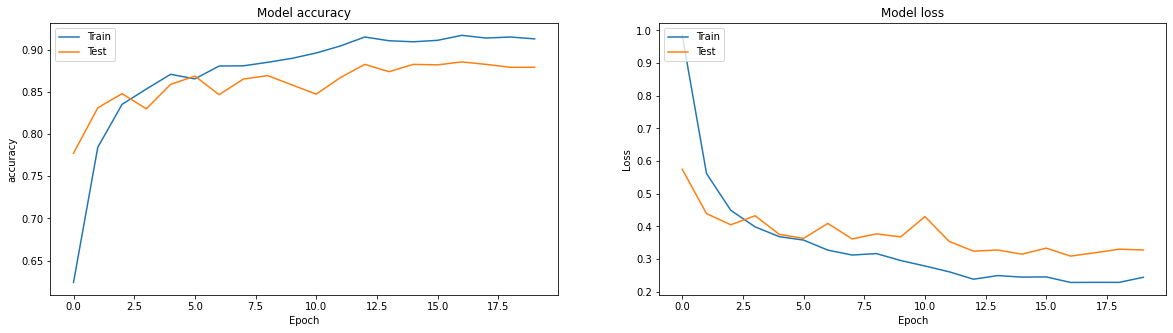

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(VGG16_model.history.history['accuracy'])
plt.plot(VGG16_model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & tets loss values
plt.subplot(122)
plt.plot(VGG16_model.history.history['loss'])
plt.plot(VGG16_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = VGG16_model.to_json()
with open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/VGG16_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Save the trained weights in to .h5 format
VGG16_model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/VGG16_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/VGG16_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/VGG16_model.h5")
print("Loaded model from disk")

Loaded model from disk


-------------------------------------------------- Confusion matrix --------------------------------------------------


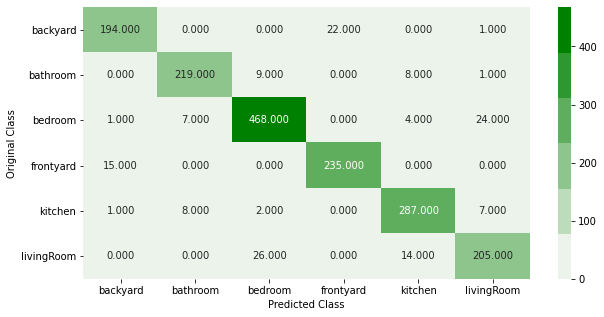

In [ ]:
predict_print_confusion_matrix(loaded_model)

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(30,30)
fig.tight_layout()
for axes_single in axes:
  for ax in axes_single:
    idx = np.random.choice(X_test.index)
    ax.axis('off')
    img = cv2.imread(X_test['image_path'][idx])
    img_orginal = cv2.resize(img,(224,224),cv2.IMREAD_UNCHANGED)
    ax.imshow(img_orginal)
    img = np.reshape(img_orginal,[1,224,224,3])
    class_prob = loaded_model.predict(img)
    ax.set_title('Actual: '+X_test['image_class'][idx]+'--> Prediction: '+predict_class(np.argmax(class_prob)))

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/VGG16_model20210913-081850

##ResNet50:

In [ ]:
gc.collect()

354

In [ ]:
ResNet50_base_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
ResNet50_base_model.trainable = False
#Input layer
input_layer1 = Input(shape=(224,224,3),name='Input_Layer1')

#Base Model layer
input_layer2 = ResNet50_base_model(input_layer1)

#Conv Layer
Conv1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=32),name='Conv1')(input_layer2)
#Batch Norm
BN1=BatchNormalization()(Conv1)
#MaxPool Layer
Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')(BN1)

#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(Pool1)

#Dropout
DO1=Dropout(.2)(flatten)

#FC layer
FC1 = Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(32),name='FC1')(DO1)

#FC layer
FC2 = Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(32),name='FC2')(FC1)

#output layer
Out = Dense(units=6,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(32),name='Output')(FC2)

#Creating a model
ResNet50_model = Model(inputs=input_layer1,outputs=Out)

In [ ]:
ResNet50_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
ResNet50_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer1 (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
Conv1 (Conv2D)               (None, 5, 5, 32)          589856    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 32)          128       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 2, 2, 32)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [ ]:
log_dir="/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/"+"ResNet50_model"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
ResNet50_model.fit(ImageGenerator_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=ImageGenerator_validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=[tensorboard_callback,reduce_lr,early_stop,lr_scheduler])
#model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/ResNet50_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
128/128 [==============================] - 3204s 25s/step - loss: 0.8153 - accuracy: 0.6808 - val_loss: 0.5080 - val_accuracy: 0.8119
Epoch 2/20
128/128 [==============================] - 867s 7s/step - loss: 0.4419 - accuracy: 0.8353 - val_loss: 0.3738 - val_accuracy: 0.8553
Epoch 3/20
128/128 [==============================] - 872s 7s/step - loss: 0.3935 - accuracy: 0.8609 - val_loss: 0.4081 - val_accuracy: 0.8409
Epoch 4/20
128/128 [==============================] - 861s 7s/step - loss: 0.3327 - accuracy: 0.8788 - val_loss: 0.3796 - val_accuracy: 0.8663
Epoch 5/20
128/128 [==============================] - 870s 7s/step - loss: 0.3010 - accuracy: 0.8852 - val_loss: 0.3872 - val_accuracy: 0.8611
Epoch 6/20
128/128 [==============================] - 875s 7s/step - loss: 0.2902 - accuracy: 0.8916 - val_loss: 0.3369 - val_accuracy: 0.8819
Epoch 7/20
128/128 [==============================] - 880s 7s/step - loss: 0.2899 - accuracy: 0.8919 - val_loss: 0.4160 - val_accuracy: 0.85

####Best Accuracy:

In [ ]:
np.max(ResNet50_model.history.history['val_accuracy'])*100

91.14583134651184

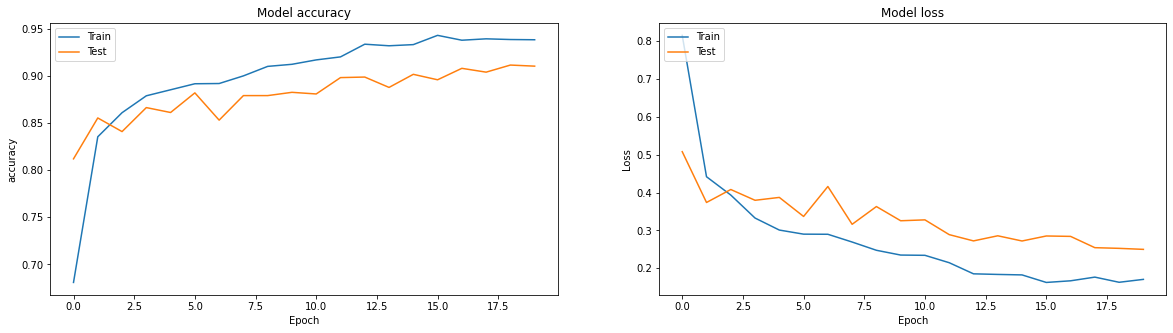

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(ResNet50_model.history.history['accuracy'])
plt.plot(ResNet50_model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & tets loss values
plt.subplot(122)
plt.plot(ResNet50_model.history.history['loss'])
plt.plot(ResNet50_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = ResNet50_model.to_json()
with open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/ResNet50_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Save the trained weights in to .h5 format
ResNet50_model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/ResNet50_model.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [ ]:
# load json and create model
json_file = open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/ResNet50_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/ResNet50_model.h5")
print("Loaded model from disk")

Loaded model from disk


-------------------------------------------------- Confusion matrix --------------------------------------------------


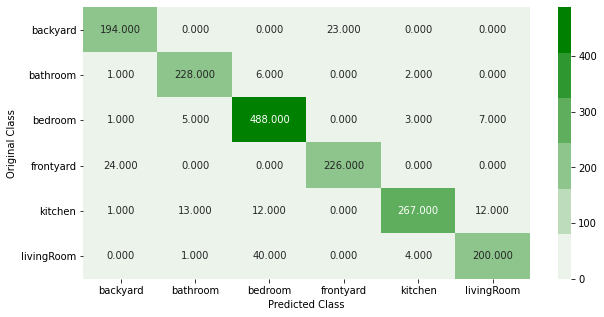

In [ ]:
predict_print_confusion_matrix(loaded_model)

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(30,30)
fig.tight_layout()
for axes_single in axes:
  for ax in axes_single:
    idx = np.random.choice(X_test.index)
    ax.axis('off')
    img = cv2.imread(X_test['image_path'][idx])
    img_orginal = cv2.resize(img,(224,224),cv2.IMREAD_UNCHANGED)
    ax.imshow(img_orginal)
    img = np.reshape(img_orginal,[1,224,224,3])
    class_prob = loaded_model.predict(img)
    ax.set_title('Actual: '+X_test['image_class'][idx]+'--> Prediction: '+predict_class(np.argmax(class_prob)))

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/ResNet50_model20210913-110523

##EfficientNetB5:

In [ ]:
EfficientNetB5_base_model=tf.keras.applications.EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
)

115277824/115263384 [==============================] - 3s 0us/step


In [ ]:
EfficientNetB5_base_model.trainable = False
#Input layer
input_layer1 = Input(shape=(224,224,3),name='Input_Layer1')

#Base Model layer
input_layer2 = EfficientNetB5_base_model(input_layer1)

#Conv Layer
Conv1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(32),name='Conv1')(input_layer2)

#Batch Norm
BN1=BatchNormalization()(Conv1)

#MaxPool Layer
Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')(BN1)

#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(Pool1)

#Dropout
DO1=Dropout(.2)(flatten)

#FC layer
FC1 = Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=32),name='FC1')(DO1)

#FC layer
FC2 = Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=33),name='FC2')(FC1)

#output layer
Out = Dense(units=6,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(seed=3),name='Output')(FC2)

#Creating a model
EfficientNetB5_model = Model(inputs=input_layer1,outputs=Out)

In [ ]:
EfficientNetB5_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
EfficientNetB5_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer1 (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
Conv1 (Conv2D)               (None, 5, 5, 32)          589856    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 32)          128       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 2, 2, 32)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [ ]:
log_dir="/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/"+"EfficientNetB5_model"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
EfficientNetB5_model.fit(ImageGenerator_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=ImageGenerator_validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=[tensorboard_callback,reduce_lr,early_stop,lr_scheduler])

#model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/EfficientNetB5_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
128/128 [==============================] - 4219s 33s/step - loss: 0.6250 - accuracy: 0.7646 - val_loss: 0.5289 - val_accuracy: 0.8166
Epoch 2/20
128/128 [==============================] - 118s 920ms/step - loss: 0.3414 - accuracy: 0.8705 - val_loss: 0.3076 - val_accuracy: 0.8866
Epoch 3/20
128/128 [==============================] - 118s 921ms/step - loss: 0.2989 - accuracy: 0.8874 - val_loss: 0.3436 - val_accuracy: 0.8796
Epoch 4/20
128/128 [==============================] - 119s 926ms/step - loss: 0.2743 - accuracy: 0.9027 - val_loss: 0.2617 - val_accuracy: 0.9045
Epoch 5/20
128/128 [==============================] - 119s 930ms/step - loss: 0.2357 - accuracy: 0.9209 - val_loss: 0.2757 - val_accuracy: 0.8953
Epoch 6/20
128/128 [==============================] - 124s 972ms/step - loss: 0.2358 - accuracy: 0.9182 - val_loss: 0.2620 - val_accuracy: 0.8970
Epoch 7/20
128/128 [==============================] - 117s 914ms/step - loss: 0.2206 - accuracy: 0.9196 - val_loss: 0.2786 - 

####Best Accuracy:

In [ ]:
np.max(EfficientNetB5_model.history.history['val_accuracy'])*100

92.01388955116272

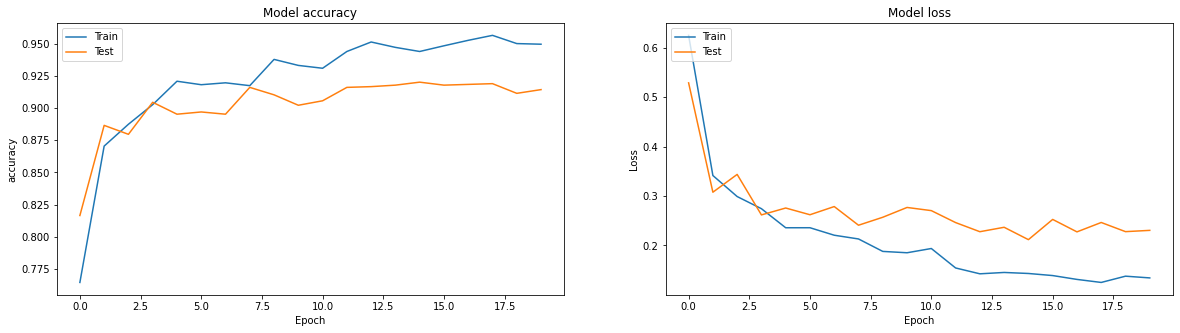

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(EfficientNetB5_model.history.history['accuracy'])
plt.plot(EfficientNetB5_model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & tets loss values
plt.subplot(122)
plt.plot(EfficientNetB5_model.history.history['loss'])
plt.plot(EfficientNetB5_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = EfficientNetB5_model.to_json()
with open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/EfficientNetB5_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Save the trained weights in to .h5 format
EfficientNetB5_model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/EfficientNetB5_model.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [ ]:
# load json and create model
json_file = open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/EfficientNetB5_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/EfficientNetB5_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.save("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Quantization_EfficientNetB5_model.h5")

-------------------------------------------------- Confusion matrix --------------------------------------------------


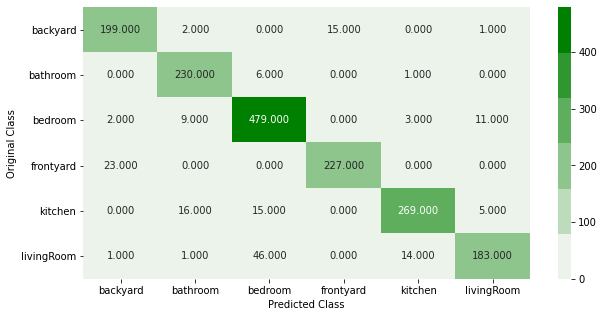

In [ ]:
predict_print_confusion_matrix(loaded_model)

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(30,30)
fig.tight_layout()
for axes_single in axes:
  for ax in axes_single:
    idx = np.random.choice(X_test.index)
    ax.axis('off')
    img = cv2.imread(X_test['image_path'][idx])
    img_orginal = cv2.resize(img,(224,224),cv2.IMREAD_UNCHANGED)
    ax.imshow(img_orginal)
    img = np.reshape(img_orginal,[1,224,224,3])
    class_prob = loaded_model.predict(img)
    ax.set_title('Actual: '+X_test['image_class'][idx]+'--> Prediction: '+predict_class(np.argmax(class_prob)))

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/EfficientNetB5_model20210914-050926

##Quantization

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

#### File Size of Model Before Quantization:

In [ ]:
convert_bytes(get_file_size("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Quantization_EfficientNetB5_model.h5"), "MB")

File size: 111.987 Megabytes


In [ ]:
before_Qnt_model=model = tf.keras.models.load_model("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Quantization_EfficientNetB5_model.h5")

####Acuuracy Of model before quantization:

In [ ]:
predict_print_model_accuracy(before_Qnt_model)*100

Accuracy:  91.9030375426621


In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(before_Qnt_model)
#tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp52wempps/assets


INFO:tensorflow:Assets written to: /tmp/tmp52wempps/assets


In [ ]:
open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/After_Quantization_EfficientNetB5_model.tflite", "wb").write(tflite_model)

32087568

#### File Size of Model After Quantization:

In [ ]:
convert_bytes(get_file_size("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/After_Quantization_EfficientNetB5_model.tflite"), "MB")

File size: 30.601 Megabytes


In [ ]:
interpreter = tf.lite.Interpreter(model_path = "/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/After_Quantization_EfficientNetB5_model.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 6]
Output Type: <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (1758, 224, 224,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1758, 6))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])


Input Shape: [1758  224  224    3]
Input Type: <class 'numpy.float32'>
Output Shape: [1758    6]
Output Type: <class 'numpy.float32'>


In [ ]:
test_data=[]
for i in X_test['image_data']:
  #test_data.append(i.astype(np.float32))
  test_data.append(i.reshape(224,224,3))

image_test_data=np.array(test_data, dtype=np.float32)
image_test_data.shape

(1758, 224, 224, 3)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], image_test_data)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (1758,6)


####Acuuracy Of tflite modelpost quantization:

In [ ]:
test_pred=[]
for row in prediction_classes:
  test_pred.append(predict_class(row))
    
print("Accuracy: ",accuracy_score(X_test["image_class"], test_pred)*100)  

Accuracy:  89.9015185422671


##Xception:

In [ ]:
Xception_base_model=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
Xception_base_model.trainable = False
#Input layer
input_layer1 = Input(shape=(224,224,3),name='Input_Layer1')

#Base Model layer
input_layer2 = Xception_base_model(input_layer1)

#Conv Layer
Conv1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(32),name='Conv1')(input_layer2)

#Batch Norm
BN1=BatchNormalization()(Conv1)

#MaxPool Layer
Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')(BN1)

#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(Pool1)

#Dropout
DO1=Dropout(.2)(flatten)

#FC layer
FC1 = Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=32),name='FC1')(DO1)

#FC layer
FC2 = Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=33),name='FC2')(FC1)

#output layer
Out = Dense(units=6,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(seed=3),name='Output')(FC2)

#Creating a model
Xception_model = Model(inputs=input_layer1,outputs=Out)

In [ ]:
Xception_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
Xception_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer1 (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
Conv1 (Conv2D)               (None, 7, 7, 32)          589856    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 3, 3, 32)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 288)               0   

In [ ]:
log_dir="/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/"+"Xception_model"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
Xception_model.fit(ImageGenerator_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=ImageGenerator_validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=[tensorboard_callback,reduce_lr,early_stop,lr_scheduler])

#model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Xception_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
128/128 [==============================] - 120s 901ms/step - loss: 1.5395 - accuracy: 0.3846 - val_loss: 1.3387 - val_accuracy: 0.4479
Epoch 2/20
128/128 [==============================] - 112s 874ms/step - loss: 1.2750 - accuracy: 0.4674 - val_loss: 1.3051 - val_accuracy: 0.4589
Epoch 3/20
128/128 [==============================] - 112s 872ms/step - loss: 1.1959 - accuracy: 0.5009 - val_loss: 1.1800 - val_accuracy: 0.4994
Epoch 4/20
128/128 [==============================] - 112s 873ms/step - loss: 1.1402 - accuracy: 0.5269 - val_loss: 1.1206 - val_accuracy: 0.5255
Epoch 5/20
128/128 [==============================] - 113s 884ms/step - loss: 1.1246 - accuracy: 0.5449 - val_loss: 1.1989 - val_accuracy: 0.5237
Epoch 6/20
128/128 [==============================] - 113s 882ms/step - loss: 1.0675 - accuracy: 0.5638 - val_loss: 1.0872 - val_accuracy: 0.5446
Epoch 7/20
128/128 [==============================] - 113s 886ms/step - loss: 1.0647 - accuracy: 0.5586 - val_loss: 1.0931 -

####Best Accuracy:

In [ ]:
np.max(Xception_model.history.history['val_accuracy'])*100

62.38425970077515

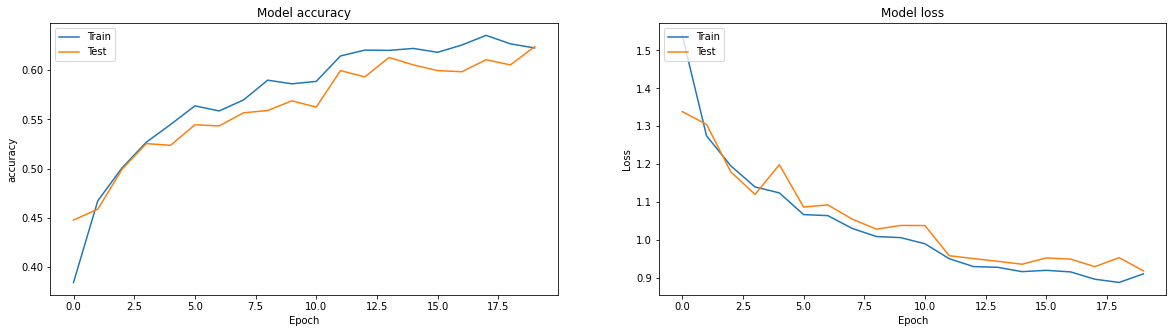

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(Xception_model.history.history['accuracy'])
plt.plot(Xception_model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & tets loss values
plt.subplot(122)
plt.plot(Xception_model.history.history['loss'])
plt.plot(Xception_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = Xception_model.to_json()
with open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Xception_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Save the trained weights in to .h5 format
Xception_model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Xception_model.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [ ]:
# load json and create model
json_file = open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Xception_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Xception_model.h5")
print("Loaded model from disk")

Loaded model from disk


-------------------------------------------------- Confusion matrix --------------------------------------------------


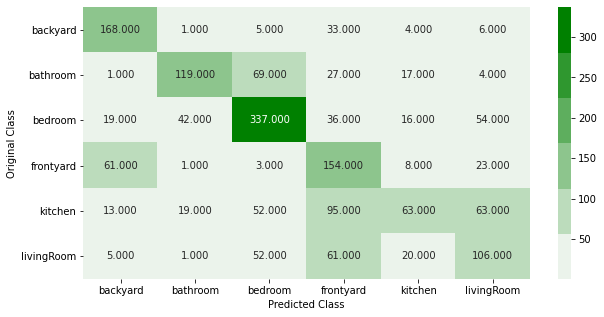

In [ ]:
predict_print_confusion_matrix(loaded_model)

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(30,30)
fig.tight_layout()
for axes_single in axes:
  for ax in axes_single:
    idx = np.random.choice(X_test.index)
    ax.axis('off')
    img = cv2.imread(X_test['image_path'][idx])
    img_orginal = cv2.resize(img,(224,224),cv2.IMREAD_UNCHANGED)
    ax.imshow(img_orginal)
    img = np.reshape(img_orginal,[1,224,224,3])
    class_prob = loaded_model.predict(img)
    ax.set_title('Actual: '+X_test['image_class'][idx]+'--> Prediction: '+predict_class(np.argmax(class_prob)))

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/Xception_model20210914-070557

##AlexNet:

In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=100, input_shape=(224,224,3), kernel_size=(11,11), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=100, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(100, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(100))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(6))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))


In [ ]:
#Model Summary

AlexNet.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 100)     36400     
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 100)     400       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 100)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 100)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 100)     250100    
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 100)     400       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 100)     0

In [ ]:
log_dir="/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/"+"AlexNet"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
AlexNet.fit(ImageGenerator_train,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=ImageGenerator_validation,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=[tensorboard_callback,reduce_lr,early_stop,lr_scheduler])

#model.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/AlexNet.h5")

Epoch 1/20
128/128 [==============================] - 119s 889ms/step - loss: 1.4711 - accuracy: 0.3718 - val_loss: 1.6779 - val_accuracy: 0.3356
Epoch 2/20
128/128 [==============================] - 113s 882ms/step - loss: 1.2528 - accuracy: 0.4706 - val_loss: 6.9279 - val_accuracy: 0.1273
Epoch 3/20
128/128 [==============================] - 125s 978ms/step - loss: 1.1769 - accuracy: 0.5080 - val_loss: 1.5314 - val_accuracy: 0.3403
Epoch 4/20
128/128 [==============================] - 126s 986ms/step - loss: 1.1219 - accuracy: 0.5490 - val_loss: 3.4884 - val_accuracy: 0.1869
Epoch 5/20
128/128 [==============================] - 112s 871ms/step - loss: 1.0739 - accuracy: 0.5635 - val_loss: 1.2713 - val_accuracy: 0.4572
Epoch 6/20
128/128 [==============================] - 112s 874ms/step - loss: 1.0490 - accuracy: 0.5820 - val_loss: 1.1504 - val_accuracy: 0.5203
Epoch 7/20
128/128 [==============================] - 124s 970ms/step - loss: 1.0178 - accuracy: 0.5920 - val_loss: 1.2215 -

####Best Accuracy:

In [ ]:
np.max(AlexNet.history.history['val_accuracy'])*100

73.72685074806213

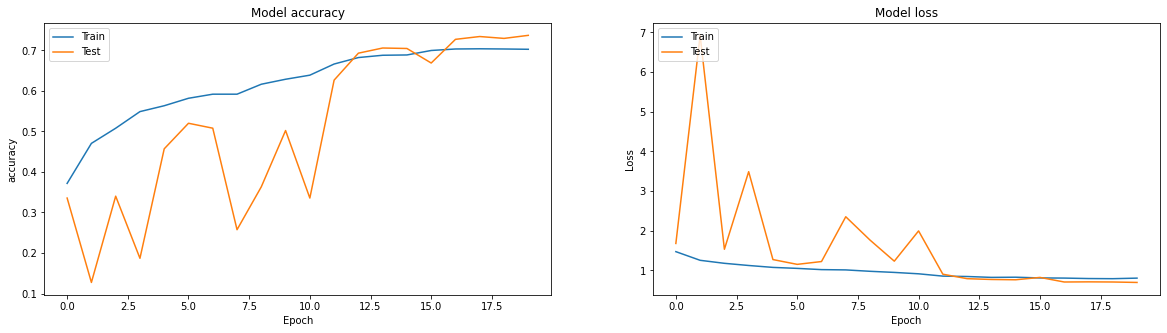

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(AlexNet.history.history['accuracy'])
plt.plot(AlexNet.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & tets loss values
plt.subplot(122)
plt.plot(AlexNet.history.history['loss'])
plt.plot(AlexNet.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = AlexNet.to_json()
with open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/AlexNet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# Save the trained weights in to .h5 format
AlexNet.save_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/AlexNet.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/AlexNet.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/AlexNet.h5")
print("Loaded model from disk")

Loaded model from disk


-------------------------------------------------- Confusion matrix --------------------------------------------------


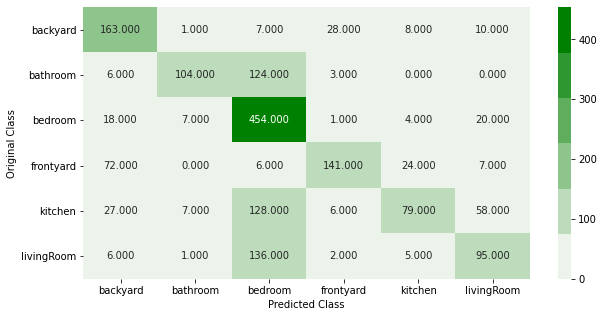

In [ ]:
predict_print_confusion_matrix(loaded_model)

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(30,30)
fig.tight_layout()
for axes_single in axes:
  for ax in axes_single:
    idx = np.random.choice(X_test.index)
    ax.axis('off')
    img = cv2.imread(X_test['image_path'][idx])
    img_orginal = cv2.resize(img,(224,224),cv2.IMREAD_UNCHANGED)
    ax.imshow(img_orginal)
    img = np.reshape(img_orginal,[1,224,224,3])
    class_prob = loaded_model.predict(img)
    ax.set_title('Actual: '+X_test['image_class'][idx]+'--> Prediction: '+predict_class(np.argmax(class_prob)))

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CASE_STUDIES/CASE_STUDY_2/Pickle_Files/Logs/AlexNet20210914-075110

##Conclusion:


In [ ]:
##Conclusion

x = PrettyTable()
x.hrules = prettytable.ALL

x.add_column('Model',['Simple Sequential Model','VGG16 Model','ResNet Model','EfficientNetB5 Model','Post Training Quantization EfficientNetB5 Model','Xception Model',
                      'AlexNet Model'])
x.add_column('Accuracy', ['40.27%','88.54%','91.14%','92.01%','89.90%','62.38%','73.72%'])

In [ ]:
print(x)


+-------------------------------------------------+----------+
|                      Model                      | Accuracy |
+-------------------------------------------------+----------+
|             Simple Sequential Model             |  40.27%  |
+-------------------------------------------------+----------+
|                   VGG16 Model                   |  88.54%  |
+-------------------------------------------------+----------+
|                   ResNet Model                  |  91.14%  |
+-------------------------------------------------+----------+
|               EfficientNetB5 Model              |  92.01%  |
+-------------------------------------------------+----------+
| Post Training Quantization EfficientNetB5 Model |  89.90%  |
+-------------------------------------------------+----------+
|                  Xception Model                 |  62.38%  |
+-------------------------------------------------+----------+
|                  AlexNet Model                  |  73